# Medical Image Classification Using MedNIST Dataset

### Introduction
The use of Artificial Intelligence (AI), and deep Convolutional Neural Networks (CNNs) in particular, has led to improvements in the speed of radiological image processing and diagnosis. This speed-up has not come at the price of accuracy; cutting-edge algorithms are comparable to the current standard of care. The best human experts still outperform AI, so the technologies being developed serve as a complement to doctors and researchers, not as their replacement. Thus, it's important that those using these new tools attain some familiarity with their inner workings.

## Dataset
The RSNA Medical Imaging Deep Learning Classroom, developed and
presented by RSNA member volunteers.
This year, the Classroom will feature a medically oriented set of images, the MedNIST database. MedNIST
comprises 1000 images each of chest radiographs, head
CTs, chest CTs, abdomen CTs, breast MRIs, and brain
MRIs. The goal is to build and train an AI model that accurately classifies images into those six categories.

In [0]:
# import libraries
import tarfile
datafile = tarfile.open("MedNIST.tar.gz")
datafile.extractall()
datafile.close()

Install MONAI

In [0]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

from monai.config import print_config
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, Resize
from monai.networks.nets import densenet201
from monai.metrics import compute_roc_auc

np.random.seed(0)
print_config()

MONAI version: 0.1.0
Python version: 3.6.9 (default, Nov  7 2019, 10:44:02)  [GCC 8.3.0]
Numpy version: 1.18.3
Pytorch version: 1.5.0+cu101
Ignite version: 0.3.0



## Read image filenames from the dataset folders
First of all, check the dataset files and show some statistics.
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
which should be used as the labels to train our classification model.

In [0]:
data_dir = './MedNIST/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Visualise some randomly picked examples from the dataset

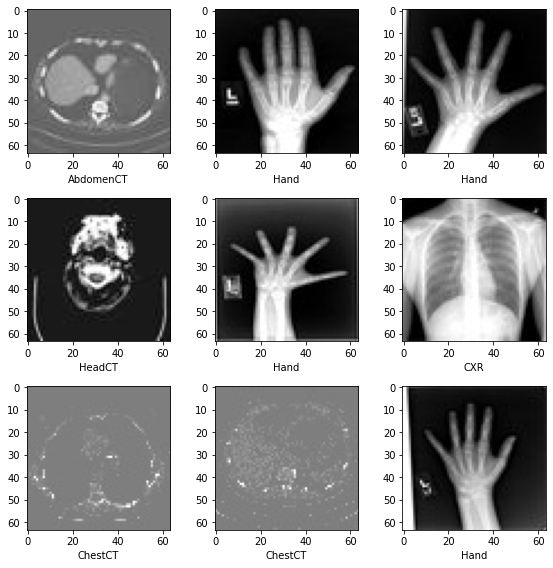

In [0]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.savefig('image.png', dpi=600)
plt.show()

## Prepare training, validation and test data lists
Randomly select 10% of the dataset as validation and 10% as test.

In [0]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 47156 Validation count = 5913 Test count = 5885


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [0]:
train_transforms = Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(degrees=15, prob=0.5),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    Resize(spatial_size=(64, 64), mode='constant'),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [0]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

## Define network and optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
And as this is just a get start tutorial, let's just train 4 epochs.
If train 10 epochs, the model can achieve 100% accuracy on test dataset.
3. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
4. Use Adam optimizer.

In [0]:
device = torch.device("cuda:0")
model = densenet201(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 5
val_interval = 1

## Model training
Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.
Will save the model weights to file if got best validation accuracy.

In [0]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch + 1, epoch_num))
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print("%d/%d,train_loss:%0.4f" % (step, len(train_ds) // train_loader.batch_size, loss.item()))
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print("epoch %d average loss:%0.4f" % (epoch + 1, epoch_loss))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, add_softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print("current epoch %d current AUC: %0.4f current accuracy: %0.4f best AUC: %0.4f at epoch %d"
                  % (epoch + 1, auc_metric, acc_metric, best_metric, best_metric_epoch))
print('train completed, best_metric: %0.4f  at epoch: %d' % (best_metric, best_metric_epoch))

----------
Epoch 1/5
1/157,train_loss:1.7948
2/157,train_loss:1.7739
3/157,train_loss:1.7564
4/157,train_loss:1.7015
5/157,train_loss:1.6877
6/157,train_loss:1.6389
7/157,train_loss:1.6112
8/157,train_loss:1.5571
9/157,train_loss:1.5783
10/157,train_loss:1.4879
11/157,train_loss:1.4874
12/157,train_loss:1.4790
13/157,train_loss:1.4100
14/157,train_loss:1.4184
15/157,train_loss:1.3801
16/157,train_loss:1.3293
17/157,train_loss:1.3192
18/157,train_loss:1.2387
19/157,train_loss:1.2582
20/157,train_loss:1.2620
21/157,train_loss:1.2518
22/157,train_loss:1.2057
23/157,train_loss:1.1389
24/157,train_loss:1.1461
25/157,train_loss:1.1038
26/157,train_loss:1.1075
27/157,train_loss:1.0902
28/157,train_loss:1.0750
29/157,train_loss:1.0355
30/157,train_loss:1.0083
31/157,train_loss:0.9498
32/157,train_loss:0.9609
33/157,train_loss:0.9560
34/157,train_loss:0.9564
35/157,train_loss:0.9253
36/157,train_loss:0.9299
37/157,train_loss:0.9033
38/157,train_loss:0.8789
39/157,train_loss:0.8399
40/157,train_

## Plot the loss and metric

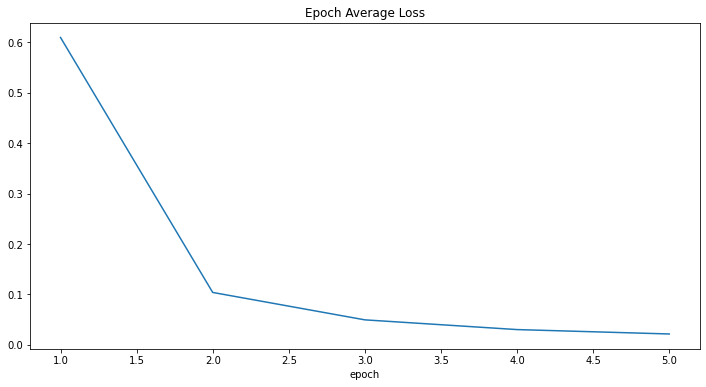

In [0]:
plt.figure('train', (12, 6))
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.savefig('epoch_loss.png', dpi=300)
plt.plot(x, y)

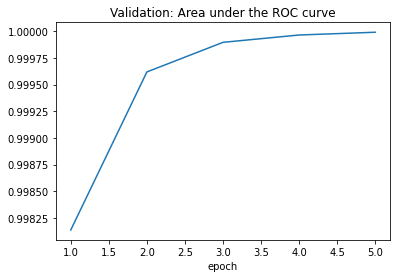

In [0]:
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.savefig('roc_curve.png', dpi=300)
plt.show()

## Evaluate the model on test dataset
After training and validation, we already got the best model on validation test.
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
We'll use these predictions to generate a classification report.

In [0]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9898    0.9969    0.9933       969
   BreastMRI     0.9989    0.9905    0.9947       944
         CXR     0.9959    1.0000    0.9979       973
     ChestCT     0.9969    1.0000    0.9984       959
        Hand     1.0000    0.9953    0.9976      1055
      HeadCT     0.9990    0.9980    0.9985       985

    accuracy                         0.9968      5885
   macro avg     0.9967    0.9968    0.9967      5885
weighted avg     0.9968    0.9968    0.9968      5885



### References
 - https://github.com/Project-MONAI/MONAI/tree/master/examples
 - https://github.com/apolanco3225/Medical-MNIST-Classification
 - https://pubs.rsna.org/doi/abs/10.1148/ryai.2019194002?journalCode=ai

In [0]:
## End of Jupyter Notebook